## Render and fit all FD curves in a selected folder

Artur Kaczmarczyk  | akaczmarczyk88@gmail.com   

Single Molecule Imaging Group | D. Rueda lab | Imperial College London | MRC LMS

version: August 11th

The script below loads all .h5 files from a folder that contain FD data and generate individual Force-Distance curves. 
Subsequently, every dataset is fitted with Worm-Like-Chain Model with predefined parameters.

NOTE: By default, if the .h5 FD curve contains both pulling and the refolding trace, the plottted and fitted graph contains only the pulling part







In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from lumicks import pylake
import os
import sys

from tkinter import filedialog        # for opening dialog window
from tkinter import *


## Import all FD curves located in a defined folder

In [18]:
# In the pop-up window, select the folder that contains .h5 files eith FD curves

root = Tk()
root.withdraw()
folder_selected = filedialog.askdirectory()
root.update()


#folder = os.getcwd( )
#filenames = os.listdir(folder)  
#Filenames = []  




# folder_selected =  r'/Users/Artur/OneDrive - Imperial College London/20200913'

filenames = os.listdir(folder_selected)          # all files in the chosen folder
Filenames = []                          

# selection of FD Curve.H5 files only

for filename in filenames:              
    if filename[-3:] == '.h5' and 'FD Curve' in filename:
        
        Filenames.append(filename)
        print(filename)
        
print(type(Filenames))

os.chdir(folder_selected)
os.getcwd()

20200825-200714 FD Curve 5.h5
20200825-200735 FD Curve 6.h5
20200825-200838 Mol1_2nM_Endo1 FD Curve 6.h5
20200825-200840 Mol1_2nM_Endo1 FD Curve 5.h5
<class 'list'>


'/Volumes/ELEMENTS/Endo 1 DATA raw and preanalysis/20200825a'

## Load WLC functions

In [15]:
### Non-extendable WLC

    ## This function returns the forces computed from a 7-parameter WLC model 
    ## [Bouchiat et al. Biophys J 76:409 (1999)]

def wlc_7param(ext, Lp, Lc):
 
    # Lp = persistence length  (in micro-m)
    # Lc = contour length      (in micro-m)
    # T  = absolute temperature (in Kelvin)
    # k_B T in units of pN micro-m
    
    #Lc = 16.49
    T = 297
    Fwlc = []
    kT = 1.3806503 * 10**(-23) *T/(10**(-18)) 
    z_L = ext/Lc

    # parameters from the paper
    my_list = [1, -0.5164228, -2.737418, 16.07497, -38.87607,  39.49944, -14.17718]   

    a = np.asarray(my_list)
    Fwlc = 1/(4*(1 - z_L)**2)  - 1/4
    
    for i in range(0,len(a)):
        Fwlc = Fwlc + a[i] * z_L**[i]


    return Fwlc * kT/Lp;


### Extendable WLC

    ## WLC model that takes stretching modulus into account


def eWLC(force, Lp, L0, S):
    F = force
    kB = 1.38e-2
    T = 297
    #S = 1800    #stretching modulus (pN)
    C = kB * T / (Lp*1000)
    
    
    d = L0 - ((L0/2)*np.sqrt(C/F)) + (F*L0/S)
    
    return(d)



def fjc(f, Pars): 
    #"""calculates a Freely Jointed Chain with a kungslength of 
    #b = 3 KbT / k*L
    #where L is the length of the fiber in nm, and k the stiffness in nm pN per nucleosome""" 
    k_Cutof = 0.2   
    if Pars['k_pN_nm'] < k_Cutof:
        Pars['k_pN_nm'] = k_Cutof
        print('>>Warning, Low stiffness, FJC breaks with low stiffness, k=', k_Cutof, 
              ' used instead. If k<', k_Cutof, ' is needed, use Hookian spring model instead')
    b = 3 * Pars['kBT_pN_nm'] / (Pars['k_pN_nm']*Pars['ZFiber_nm'])
    x = f * b / Pars['kBT_pN_nm']
    z = (np.exp(x) + 1 / np.exp(x)) / (np.exp(x) - 1 / np.exp(x)) - 1 / x
    #coth(x)= (exp(x) + exp(-x)) / (exp(x) - exp(x)) --> see Wikipedia
    #z *= Pars['L_bp']*Pars['DNAds_nm']   #work /dG term not used atm
    #z_df = (Pars['kBT_pN_nm'] / b) * (np.log(np.sinh(x)) - np.log(x))  #*L_nm #  + constant --> integrate over f (finish it
    #w = f * z - z_df
    return z * (Pars['N_tot']-Pars['N4'])




In [16]:
# LEAST SQUARE METHOD is used to fit the persistence length and the contour length beased on the non-eWLC

# Predefine the expected range (in micrometers)
PL_min = 0.015 
PL_max = 0.055
CL_min = 4.5
CL_max = 5.5
S_min = 900 # pN
S_max = 1500 #pN


# Choose the part of the data to be fitted   

force_treshold = 18     # pN  
force_treshold_min = 2  # pN


Force-distance curve I.D. = ['5']
Force-distance curve I.D. = ['6']
Force-distance curve I.D. = ['6']
Force-distance curve I.D. = ['5']


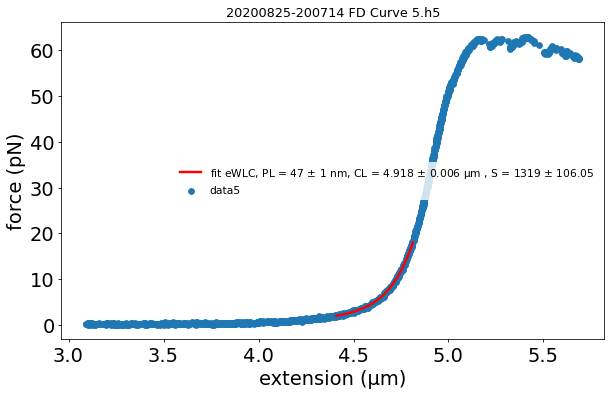

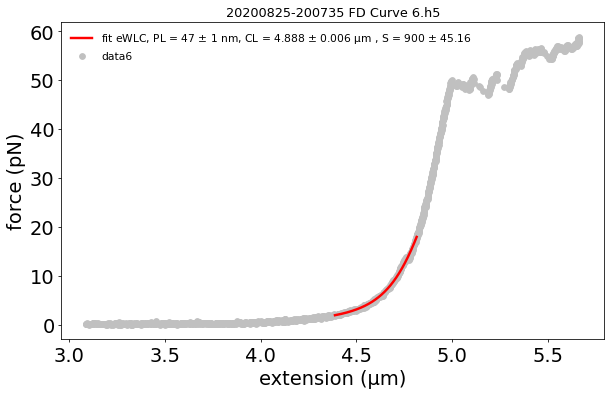

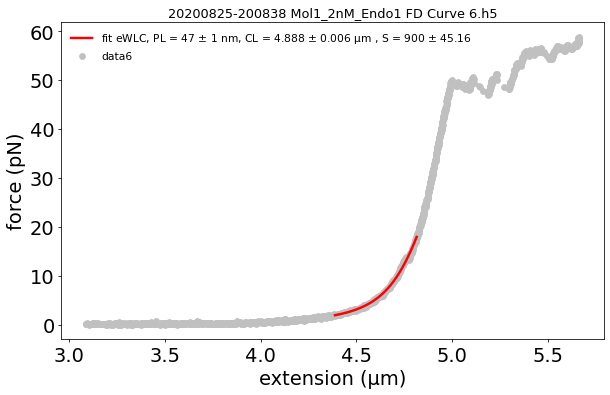

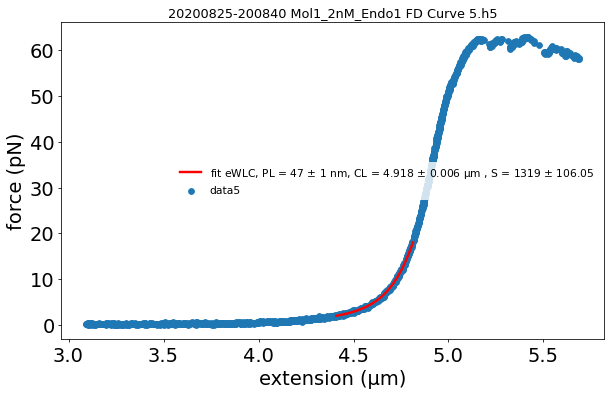

In [19]:
for k in range(len(Filenames)):
    
    
    file = pylake.File(Filenames[k])
    print("Force-distance curve I.D. = " + str(list(file.fdcurves)))
    curve_number = (list(file.fdcurves))   
    
    
    index = 0 # keep ZERO when there is only one FD curve within the .h5 file, increments +1 would correspond with the list of indexes for remaining FD curve generated in the same .h5 file
    
    fd = file.fdcurves[(curve_number[index])]
    force = fd.f
    distance = fd.d

    
    # Stretching curve
    plt.figure(figsize=(10, 6), dpi=70)
    if np.sum(np.diff(distance.data[0:100])) > 0:   # checks if the first data points have increasing distance
    #if np.sum(np.diff(distance.data)) > 0:   # checks if the first data points have increasing distance

        
        plt.scatter(distance.data,force.data, s = 35)

        indices_bottom = [i for i,v in enumerate(force.data > force_treshold_min ) if v]
        indices_top = [i for i,v in enumerate(force.data > force_treshold) if v]
        b1 = indices_bottom[0]
        b2 = indices_top[0]

        popt, pcov = curve_fit(eWLC, force.data[b1:b2], distance.data[b1:b2], bounds=([PL_min,CL_min,S_min],[PL_max,CL_max,S_max]))
        perr = np.sqrt(np.diag(pcov)) # standard deviation errors of the parameters
        
        np.savetxt(str(Filenames[k][:-3])+'_fit_'+ (curve_number[index]) + '.csv' , np.c_[distance.data, force.data], delimiter=",")
    
        plt.plot(eWLC(np.linspace(force_treshold_min,force_treshold,1000), *popt),np.linspace(force_treshold_min,force_treshold,1000),  'r-',linewidth=2.5, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt))

    
    # Refolding curve
    #if np.sum(np.diff(distance.data)) < 0:
    else:                                      ## if the distance is decreasing in the array, it means we have a refolding curve only
        plt.scatter(distance.data, force.data, s = 35, color = 'silver')
    
        indices_bottom = [i for i,v in enumerate(force.data > force_treshold_min ) if v]
        indices_top = [i for i,v in enumerate(force.data < force_treshold) if v]
        b1 = indices_bottom[-1]
        b2 = indices_top[0]  
        
        popt, pcov = curve_fit(eWLC,  force.data[b2:b1], distance.data[b2:b1], bounds=([PL_min,CL_min,S_min],[PL_max,CL_max,S_max]))
        perr = np.sqrt(np.diag(pcov)) # standard deviation errors of the parameters
   
        np.savetxt(str(Filenames[k][:-3])+'_fit_'+ (curve_number[index]) + '.csv' , np.c_[distance.data, force.data], delimiter=",")

        plt.plot(eWLC(np.linspace(force_treshold_min,force_treshold,1000), *popt), np.linspace(force_treshold_min,force_treshold,1000),  'r-',linewidth=2.5, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt))

        
    
    plt.xlabel('extension (\u03BCm)')    
    plt.ylabel('force (pN)')   
    
    #plt.xlim(3, 5.5)
    #plt.ylim(10, 30)
    
    plt.rc('font', size=11)
    plt.title(str(Filenames[k]))
    leg = plt.legend(('fit eWLC, PL = '+ str(round(popt[0]*1000))+ ' $ \pm $ '+ str(round(perr[0]*1000)) + ' nm, CL = '+str(round(popt[1],3))+ ' $ \pm $ '+ str(round(perr[1],3)) +' \u03BCm , S = ' + str(round(popt[2])) + ' $ \pm $ '+ str(round(perr[2],2)) ,'data'+str((curve_number[index]))))
    leg.get_frame().set_linewidth(0.0)

    plt.savefig(str(Filenames[k][:-3])+'_plot_' + (curve_number[index]) + '.png', dpi=300, bbox_inches='tight')
    #np.savetxt('Fd_'+ (curve_number[index]) + '.csv' , np.c_[distance.data[np.argmax(force.data):len(force.data)], force.data[np.argmax(force.data):len(force.data)]], delimiter=",")
    #np.savetxt('Fd_fit'+ (curve_number[index]) + '.csv' , np.c_[d_wave, f_wave], delimiter=",")

    plt.rc('font', size=20)


    #plt.plot(d_wave2, f_wave,'--',color = 'silver')
    #plt.xlabel('extension (\u03BCm)')    
    #plt.ylabel('force (pN)')   
    #plt.xlim(4.8, 4.9)
    #plt.ylim(15, 30)
    #plt.savefig('zoom_FD_' + (curve_number[index]) + '.png', dpi=300, bbox_inches='tight')

